In [1]:
from functions import vectorize_y_ser

In [2]:
import datetime

In [3]:
import nltk
import string

In [4]:
import re

In [5]:
import pickle

In [6]:
import pandas as pd
import numpy as np

In [7]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [9]:
from collections import Counter

In [10]:
from imblearn.under_sampling import RandomUnderSampler

In [11]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# NLP Pipeline 

![](images/pipeline-walkthrough1.png)

Below is a to do list when converting text into vector form: 

**Clean text and Create a Bag of Words (BoW)**
>1. Lowercase the text
2. Tokenize 
3. Strip out punctuation or undesirable text
4. Remove Stopwords 
5. Stemming or Lemmatizing
6. Compute N-Grams
7. Use this to create BoW

**Vectorize BoW**
>8. Term Frequencies
9. Document Frequencies
10. TF-IDF
11. Normalize vectors

Let's go through both what each of these steps are and how to do them in python with the following corpus of comments about data science...
 

In [12]:
# function to vectorize the type_of_material series into a y target vector.
def vectorize_y_ser(ser):
    y = ser.copy()
    y.replace({'Op-Ed': 1,'News': 0}, inplace=True)
    return y

In [13]:
#rate of correct predictions out of total predictions
def metrics_(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tn + fn + tp + fp)
    print(f'Accuracy: {round(accuracy, 2)}')
    recall = (tp) / (tp + fn)
    print(f'Recall: {round(recall, 2)}')
    precision = (tp) / (tp + fp)
    print(f'Precision: {round(precision, 2)}')
    print(f'TN:{tn} FP:{fp} FN:{fn} TP:{tp}')
    return (accuracy, recall, precision)

In [14]:
#prints number of features, stop words and parameters for vectorizer
def vectorizer_parameters(vectorizer):
    #features
    feat_names = vectorizer.get_feature_names()
    num_feat = len(feat_names)
    
    #stop words
    stop_words = vectorizer.stop_words_
    num_stop = len(stop_words)

    params = vectorizer.get_params()
    
    print(f'Number of features: {num_feat}, Numbers of stop words: {num_stop}')
      
    for key, val in params.items():
        print(f'{key}: {val}')

In [15]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~”’“':
            document = document.replace(char, " ") 
    return document

In [16]:
#combine print, type, text columns in the list
def printed(file):
    print_cols = ['_id','print_page','pub_date','keywords','type_of_material','lead_paragraph','text']    
    df = pd.read_csv(file, usecols=print_cols, index_col='_id', low_memory=False)
    df = df[df.print_page.isna() == False]
    df = df[~df.text.isna() == True]
    return df

In [17]:
#returns articles w/ 'United States Politics and Government' as a keyword
def return_pol_gov(row):
    list_dict = eval(row.keywords)
    for (dic) in (list_dict):
        if dic.get('value') == 'United States Politics and Government':
            return True

In [18]:
def filter_keyword(df, keyword='United States Politics and Government'):
    df[keyword] = df.apply(return_pol_gov, axis=1)
    df = df[df[keyword] == True]
    return df

In [19]:
#returns shape of news and oped
def oped_v_news(df):
    df.type_of_material.hist()
    news = sum(df.type_of_material == "News")
    oped = sum(df.type_of_material == "Op-Ed")
    print(f'News: {news} Oped: {oped}, Total: {oped+news}, Op-Ed {round(oped/(oped+news), 2)} of total')
    #plt.savefig('img/oped_news_hist.png')

In [20]:
#split article and return quote
def return_quote(document):
    article = []
    quote_list = []
    
    open_quote = "“"
    close_quote = "”"
    
    close_split = document.split(close_quote)
    
    for string in close_split:

        quote = string.split(open_quote)
        article.append(quote.pop(0))
        quote_list += quote
    
    article = " ".join(article)
    quotation = " ".join(quote_list)
        
    return(quotation)

In [21]:
#split article and return quote
def return_article(document):
    article = []
    quote_list = []
    
    open_quote = "“"
    close_quote = "”"
    
    close_split = document.split(close_quote)
    
    for string in close_split:

        quote = string.split(open_quote)
        article.append(quote.pop(0))
        quote_list += quote
    
    article = " ".join(article)
    quotation = " ".join(quote_list)
    
    return(article)

In [22]:
data = pd.read_csv('token_2010_2020.csv', index_col='_id')

In [23]:
%%time
df = data.copy()

CPU times: user 1.95 ms, sys: 402 µs, total: 2.35 ms
Wall time: 2.34 ms


In [24]:
df.shape

(27461, 9)

In [25]:
df = filter_keyword(df)

In [26]:
df.head()

,lead_paragraph,keywords,pub_date,type_of_material,print_page,text,United States Politics and Government,quote_list,keyword_list
_id,,,,,,,,,
nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e,"On the first Monday in May, the Department of ...","[{'name': 'persons', 'value': 'Barr, William P...",2020-06-01T09:00:11+0000,News,20.0,as you drew closer to the fifth floor where ...,True,[[]],"['', 'Barr,', 'William', 'P', 'Justice', 'Depa..."
nyt://article/0fa09b77-5faa-588f-9d4a-39a34748c7f3,"Under normal circumstances, Joseph R. Biden Jr...","[{'name': 'subject', 'value': 'Presidential El...",2020-06-01T09:01:09+0000,News,14.0,at a moment that is emerging as a critical te...,True,[[]],"['', 'Presidential', 'Election', 'of', '2020',..."
nyt://article/6b274a69-c82b-5b68-bada-ec1467440ddf,The Supreme Court on Monday unanimously upheld...,"[{'name': 'organizations', 'value': 'Supreme C...",2020-06-01T16:38:59+0000,News,15.0,court ruled that members of a government boar...,True,[[]],"['', 'Supreme', 'Court', '(US)', 'Puerto', 'Ri..."
nyt://article/8867f9cb-5914-5731-90b9-e1f1781fa568,"An international team of scientists, including...","[{'name': 'subject', 'value': 'Coronavirus (20...",2020-06-01T16:42:18+0000,News,6.0,their report posted online they also point t...,True,[[]],"['', 'Coronavirus', '(2019-nCoV)', 'Bats', 'SA..."
nyt://article/fb5f6e07-033e-5618-967e-fbc1ebcfd61c,WASHINGTON — President Trump on Monday angrily...,"[{'name': 'subject', 'value': 'George Floyd Pr...",2020-06-01T17:20:54+0000,News,1.0,said in brief remarks in the the presiden...,True,[[]],"['', 'George', 'Floyd', 'Protests', '(2020)', ..."


In [27]:
df.text.iloc[0]

' as you drew closer to the fifth floor where      works out of a suite of offices things started to loosen up  assistant outside his conference room wore a mask but the other did not  the middle of the room with its oil paintings and vaulted ceiling the long central table had fewer chairs than you might expect and an appropriate distance between them  past the next door inside the attorney generals smaller personal office  himself was also mask-free  around to greet his visitors he moved into the middle of a wide circle of four chairs arranged in front of his desk  nearing the end of his career  did not take his current job for the glory  had already been attorney general once in      administration winning him a reputation as a wise old man a reputation that in the eyes of some his tenure in the  administration has tarnished  is he doing it for the money  time in corporate  earned him tens of millions of dollars in compensation and stock options and his bearing is still that of a  50

In [28]:
last_check_before_split = (df.iloc[0])
last_check_before_split

lead_paragraph                           On the first Monday in May, the Department of ...
keywords                                 [{'name': 'persons', 'value': 'Barr, William P...
pub_date                                                          2020-06-01T09:00:11+0000
type_of_material                                                                      News
print_page                                                                            20.0
text                                      as you drew closer to the fifth floor where  ...
United States Politics and Government                                                 True
quote_list                                                                            [[]]
keyword_list                             ['', 'Barr,', 'William', 'P', 'Justice', 'Depa...
Name: nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e, dtype: object

News: 22160 Oped: 5301, Total: 27461, Op-Ed 0.19 of total


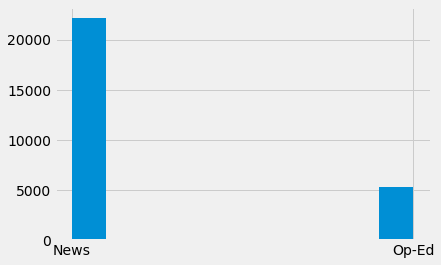

In [29]:
oped_v_news(df)

# drop na

In [30]:
df.shape

(27461, 9)

In [31]:
df = df.dropna()

In [32]:
df.shape

(27406, 9)

# X, y

In [33]:
#define X. X is currently pandas series of unsplit strings
X = df.text

In [34]:
#turn series into list...
corpus = list(X)

In [35]:
corpus[0]

' as you drew closer to the fifth floor where      works out of a suite of offices things started to loosen up  assistant outside his conference room wore a mask but the other did not  the middle of the room with its oil paintings and vaulted ceiling the long central table had fewer chairs than you might expect and an appropriate distance between them  past the next door inside the attorney generals smaller personal office  himself was also mask-free  around to greet his visitors he moved into the middle of a wide circle of four chairs arranged in front of his desk  nearing the end of his career  did not take his current job for the glory  had already been attorney general once in      administration winning him a reputation as a wise old man a reputation that in the eyes of some his tenure in the  administration has tarnished  is he doing it for the money  time in corporate  earned him tens of millions of dollars in compensation and stock options and his bearing is still that of a  50

In [36]:
# define y as a series of op-ed or news
y = df.type_of_material

In [37]:
vectorize_y_ser(y)

_id
nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e    0
nyt://article/0fa09b77-5faa-588f-9d4a-39a34748c7f3    0
nyt://article/6b274a69-c82b-5b68-bada-ec1467440ddf    0
nyt://article/8867f9cb-5914-5731-90b9-e1f1781fa568    0
nyt://article/fb5f6e07-033e-5618-967e-fbc1ebcfd61c    0
                                                     ..
nyt://article/8ebe71ee-2cbe-5c25-8d4a-91696cff67d4    0
nyt://article/87f0a2b8-39f6-5fb5-a076-a4949353400e    0
nyt://article/a6e31872-431b-5b24-8d35-dfae18af1f0c    0
nyt://article/bd4bc1cd-7cbc-525e-a65c-76c6b338e331    0
nyt://article/a56ad218-e173-568e-b4b5-ddd584ec79cb    0
Name: type_of_material, Length: 27406, dtype: int64

In [38]:
%%time
# vectorize y in to (1, 0) (op-ed, news)
y = vectorize_y_ser(y)

CPU times: user 8.76 ms, sys: 792 µs, total: 9.55 ms
Wall time: 8.94 ms


In [39]:
y.value_counts()

0    22122
1     5284
Name: type_of_material, dtype: int64

In [40]:
y.shape
X.shape

(27406,)

# remove stop words

# stemming/lemmatization

In [41]:
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

In [42]:
# %%time
# def snowball_tokenize(doc):
#     snowball = SnowballStemmer('english')
#     return [snowball.stem(word) for word in word_tokenize(doc.lower())]

In [43]:
%%time
def wordnet_tokenize(doc):
    wordnet = WordNetLemmatizer()
    return  [wordnet.lemmatize(word) for word in word_tokenize(doc.lower())]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


# vectorizer

# WORDNET tfidf

In [44]:
import string

In [45]:
print(string.punctuation)
print('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [46]:
# nytimes_quotes = "”“"
# nytimes_punctuation = "—’"

In [47]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~':
            document = document.replace(char, " ")
    return document

In [93]:
stop_words_nlp = ['week',
 'these',
 'what',
 'seems',
 'very',
 'think',
 'get',
 'story',
 'people',
 'reality',
 'largely',
 'rich',
 'brought',
 'good',
 'major',
 'provided',
 'after',
 'enough',
 'will',
 'why',
 'feel',
 'them',
 'even',
 'behavior',
 'fact',
 'clearly',
 'should',
 'there',
 'kind',
 'actually',
 'future',
 'talking',
 'do',
 'life',
 'campaign',
 'want',
 'course',
 'adding',
 'different',
 'understand',
 'like',
 'seem',
 'world',
 'thinking',
 'filed',
 'true',
 'administration',
 'office',
 '14',
 'pushed',
 'may',
 'secretary',
 'saying',
 'criticized',
 'several',
 'respect',
 'else',
 'need',
 'considered',
 'chairman',
 'two',
 'look',
 'later',
 'day',
 'telephone',
 'visit',
 'important',
 'looked',
 'veteran',
 'mind',
 'mean',
 'got',
 'message',
 'keep',
 'voter',
 'real',
 'ever',
 'anything',
 'believed',
 '1',
 'done',
 'letter',
 'added',
 'everyone',
 'ask',
 'bit',
 'supposed',
 'problem',
 'under',
 'practice',
 'modern',
 'information',
 'sound',
 'group',
 'leader',
 'top',
 'committee',
 'member',
 'intended',
 'lot',
 'hero',
 '32',
 'conspiracy',
 'known',
 'security',
 'let',
 'fair',
 'fail',
 'yes',
 'intellectual',
 'department',
 'conference',
 'endorsement',
 'director',
 'month',
 'approved',
 'official',
 'oversees',
 'billion',
 'acknowledged',
 'professor',
 '2',
 'earlier',
 'decision',
 'solve',
 'provision',
 'legislation',
 'proposed',
 'attitude',
 'review',
 'declined',
 'rally',
 'preparing',
 'sent',
 'issued',
 'series',
 'seeking',
 'briefing',
 'rid',
 'struggled',
 'interview',
 'disclosure',
 'testified',
 'additional',
 'prosecutor',
 'deputy',
 'aide',
 'except',
 'enemy',
 'evening',
 'internal',
 'referring',
 'politician',
 'founder',
 'counsel',
 'obtained',
 'released',
 'practiced',
 'outlined',
 'replied',
 'hosted', 'including',
 'effort',
 'before',
 'largest',
 'accused',
 'force',
 '000',
 'officer',
 'nearly',
 'former',
 'move',
 'night',
 'document',
 'request',
 'continued',
 'issue',
 'called',
 'legal',
 'stretched',
 'range',
 'unusual',
 'staff',
 'expressed',
 'according',
 'nearby',
 'joined',
 'car',
 'forward',
 '6',
 '9',
 'measure',
 'primary',
 'final',
 'drew',
 'represents',
 'potentially',
 'nominee',
 'posted',
 'prominent',
 'include',
 'adviser',
 'strategist',
 'worked',
 'team',
 'remained',
 'lawyer',
 'afternoon',
 'senator',
 'proposal',
 'seat',
 'pleaded',
 'appeared',
 'increase',
 'agreed',
 'announced',
 'spokesman',
 'familiar',
 'convened',
 'sought',
 'online',
 'planned',
 'comment',
 'quickly',
 'senior',
 'expert',
 'meeting',
 'repeatedly',
 'appearance',
 'contest',
 'hoped',
 'agency',
 'inquiry',
 'announcement',
 'negotiation',
 'anonymity',
 'aimed',
 'detail',
 'discussed',
 'daughter',
 'scheduled',
 'lawmaker',
 'producer',
 'ranking',
 'remark',
 'mercurial', 'against',
 'news',
 'close',
 'did',
 'other',
 'role',
 'began',
 'could',
 'chief',
 'expected',
 'three',
 'during',
 'support',
 'since',
 'statement',
 'wrote',
 'focused',
 'last',
 'asked',
 'general',
 'spoke',
 'tried',
 'heavily',
 'urged',
 'agreement',
 'she',
 'email',
 'plan',
 'business',
 'dispute',
 'emphasized',
 'provide',
 'served',
 'speaking',
 'set',
 'attended',
 'brief',
 'noted',
 'longtime',
 'special',
 'company',
 'morning',
 'criticism',
 'viewed',
 'citing',
 'entered',
 'signature',
 'initially',
 'received',
 'executive',
 'advocacy',
 'ambassador',
 'floor',
 'privately',
 'scrutiny',
 'overhaul',
 'illegally',
 'briefed',
 'frequently',
 'fund',
 'bolster',
 'tie',
 'questioned',
 'assistant',
 'intends',
 'panel',
 'stance',
 'unclear',
 'commenting',
 'negotiating',
 'rang',
 'sow',
 'undecided',
 'allegation',
 'overly',
 'spokeswoman',
 'advertisement',
 'regulator']

In [94]:
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

In [95]:
stop_words = alphabet + stop_words_nlp

In [96]:
%%time
#create vectorizer

vectorizer = TfidfVectorizer(#input='content', 
#                 encoding='utf-8', 
#                 decode_error='strict', 
#                 strip_accents='ascii', 
#                 lowercase=True, 
                 preprocessor=punc_strip, 
                 tokenizer=wordnet_tokenize, 
#                 analyzer='word', 
                 stop_words=stop_words,
#                 token_pattern='(?u)\b\w\w+\b', 
#                 ngram_range=(1, 2), 
                 max_df=0.7, 
#                 min_df=0.1, 
                 max_features=None, 
#                 vocabulary=None, 
#                 binary=False, 
#                 dtype=<class 'numpy.float64'>, 
#                 norm='l2', 
#                 use_idf=True, 
#                 smooth_idf=True, 
#                 sublinear_tf=False
)

CPU times: user 1.73 ms, sys: 8.29 ms, total: 10 ms
Wall time: 10 ms


# test, train, split

In [97]:
#test, train, split

In [98]:
%%time
#test, train, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train = vectorizer.fit_transform(X_train)

X_test = vectorizer.transform(X_test)

(20554,) (6852,) (20554,) (6852,)
CPU times: user 2min 12s, sys: 291 ms, total: 2min 12s
Wall time: 2min 12s


In [99]:
X_train.shape

(20554, 44899)

In [100]:
X_test.shape

(6852, 44899)

# count vectorizer

In [101]:
# count_vectorizer = CountVectorizer(strip_accents='None',
#                                    lowercase=True,
#                                    tokenizer=snowball_tokenize,
#                                    stop_words='english',
#                                    max_features=None)

# balance classes

In [102]:
%%time
#balance the classes

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

#X, y --> X_resampled, y_resampled
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))
print(rus)

[(0, 3981), (1, 3981)]
RandomUnderSampler(random_state=0)
CPU times: user 15.2 ms, sys: 5.03 ms, total: 20.2 ms
Wall time: 19.3 ms


# random forest classifier

In [103]:
%%time
print(datetime.datetime.now())
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)

2021-01-11 22:19:41.978233
CPU times: user 386 µs, sys: 47 µs, total: 433 µs
Wall time: 437 µs


In [104]:
rf_clf.fit(X_resampled, y_resampled)
y_pred = rf_clf.predict(X_test)
y_pred.shape

(6852,)

### metrics y_pred

In [105]:
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = y_pred).ravel()

In [106]:
print(y_test.shape)
print(y_pred.shape)

(6852,)
(6852,)


In [107]:
metrics_(tn, fp, fn, tp)

Accuracy: 0.9
Recall: 0.82
Precision: 0.71
TN:5118 FP:431 FN:237 TP:1066


(0.9025102159953299, 0.8181120491174213, 0.7120908483633934)

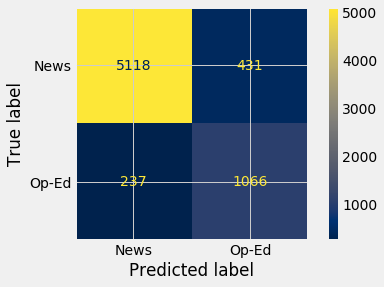

In [108]:
class_names = ["News", "Op-Ed"]
plot_confusion_matrix(estimator=rf_clf,
                      X=X_test,
                      y_true=y_test,
                      display_labels=class_names,
                      cmap='cividis')
plt.savefig('img/confusion_matrix.png');

# vectorizer parameters

In [109]:
vectorizer_parameters(vectorizer)

Number of features: 44899, Numbers of stop words: 40
analyzer: word
binary: False
decode_error: strict
dtype: <class 'numpy.float64'>
encoding: utf-8
input: content
lowercase: True
max_df: 0.7
max_features: None
min_df: 1
ngram_range: (1, 1)
norm: l2
preprocessor: <function punc_strip at 0x7fd2a5885c20>
smooth_idf: True
stop_words: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'week', 'these', 'what', 'seems', 'very', 'think', 'get', 'story', 'people', 'reality', 'largely', 'rich', 'brought', 'good', 'major', 'provided', 'after', 'enough', 'will', 'why', 'feel', 'them', 'even', 'behavior', 'fact', 'clearly', 'should', 'there', 'kind', 'actually', 'future', 'talking', 'do', 'life', 'campaign', 'want', 'course', 'adding', 'different', 'understand', 'like', 'seem', 'world', 'thinking', 'filed', 'true', 'administration', 'office', '14', 'pushed', 'may', 'secretary', 'saying', 'criticized', 'several', 'resp

# important features

### feature imporance

2021-01-11 22:19:43.840875
CPU times: user 385 ms, sys: 32.3 ms, total: 417 ms
Wall time: 415 ms


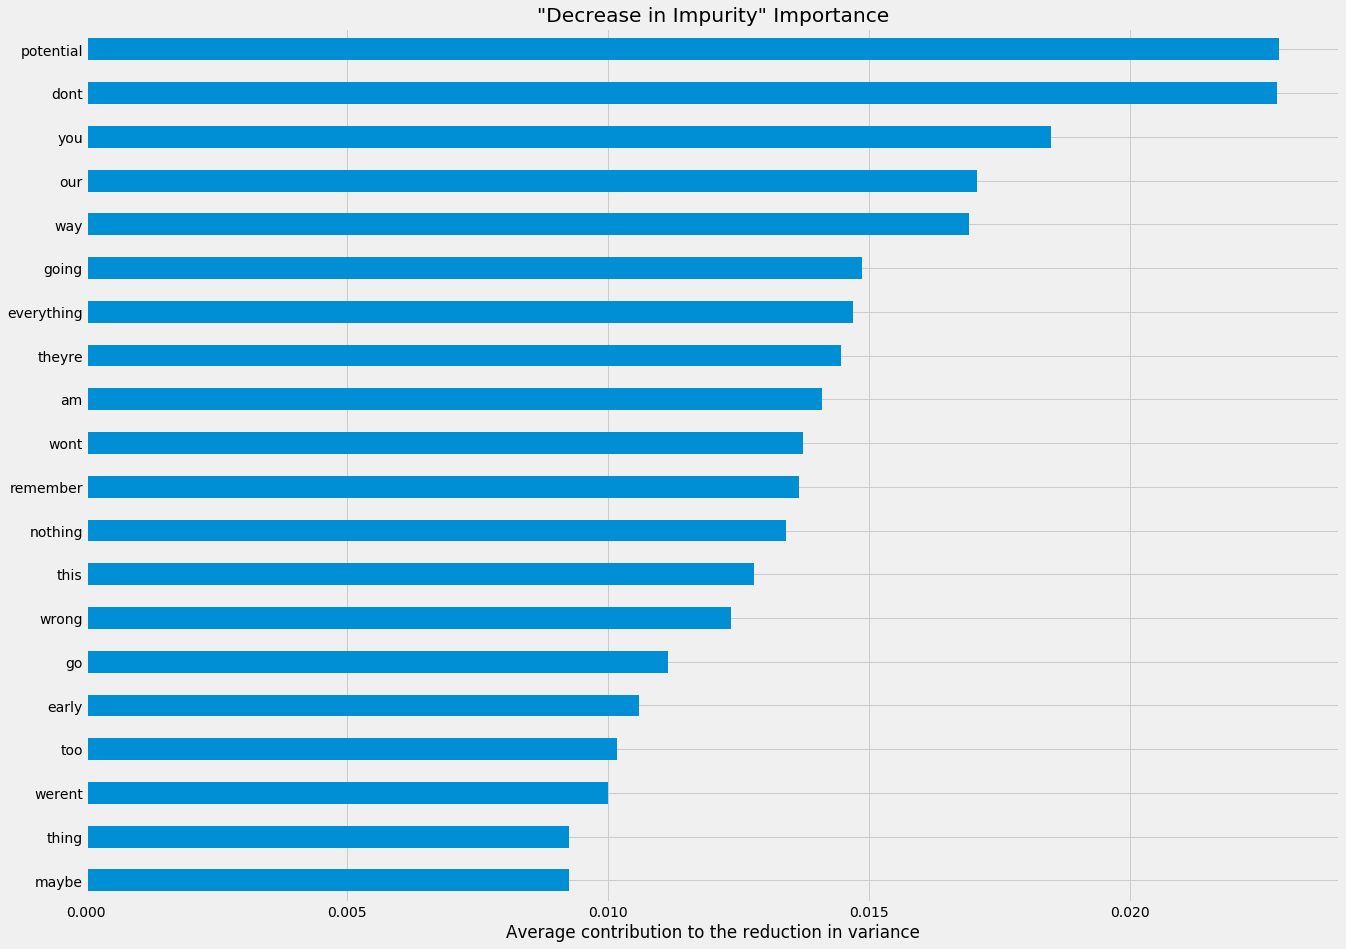

In [110]:
%%time
print(datetime.datetime.now())

feat_names = vectorizer.get_feature_names()
feature_import = rf_clf.feature_importances_

feat_scores = pd.Series(feature_import, index=feat_names)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-20:].plot(kind='barh', figsize=(20,15))
ax.set_title('"Decrease in Impurity" Importance')
ax.set_xlabel('Average contribution to the reduction in variance')
plt.savefig('img/feature_imporance.png');

In [111]:
feat_scores[-100:].index

Index(['related', 'indicated', 'concerned', 'supposedly', 'employee', 'file',
       'praised', 'decided', 'cynical', 'crowd', 'sure', 'success', 'getting',
       'age', 'realized', 'led', 'wing', 'offered', 'anyone', 'come', 'behave',
       'hack', 'civilization', 'manager', 'something', 'just', 'turn',
       'somehow', 'among', 'law', 'find', 'forget', 'youve', 'authoritarian',
       'reporter', 'happened', 'actual', 'hasnt', 'man', 'sense', 'concern',
       'self', 'poor', 'five', 'unit', 'century', 'described', 'democracy',
       'radical', 'corrupt', 'make', 'once', 'no', 'happen', 'elite', 'first',
       'now', 'someone', 'politics', 'whats', 'if', 'must', 'here', 'kid',
       'probably', 'investigation', 'firm', 'indeed', 'youre', 'wouldnt',
       'pretty', 'guy', 'doesnt', 'isnt', 'bad', 'thats', 'can', 'all',
       'arent', 'raised', 'maybe', 'thing', 'werent', 'too', 'early', 'go',
       'wrong', 'this', 'nothing', 'remember', 'wont', 'am', 'theyre',
       'everyt

In [112]:
count_df = df[['text', 'type_of_material']]
oped = count_df[count_df['type_of_material'] == "Op-Ed"]
news = count_df[count_df['type_of_material'] == "News"]

In [113]:
print(oped.shape)
print(news.shape)

(5284, 2)
(22122, 2)


In [114]:
oped_string = oped.text.str.cat(sep = " ")
num_oped_string = len(oped_string)
print(num_oped_string)

22230502


In [115]:
news_string = news.text.str.cat(sep = " ")
num_news_string = len(news_string)
print(num_news_string)

102867068


# counting

In [138]:
top_50 = feat_scores[-5:].index

In [139]:
%%time
oped_list = [word for word in oped_string.split() if word in list(top_50)]
oped_ed_counter = Counter(oped_list)
oped_ed_counter.items()

CPU times: user 5.03 s, sys: 28.7 ms, total: 5.06 s
Wall time: 5.06 s


dict_items([('dont', 3328), ('you', 8415), ('way', 4821), ('our', 8763), ('potential', 554)])

In [140]:
%%time
news_list = [word for word in news_string.split() if word  in list(top_50)]
news_counter = Counter(news_list)
news_counter.items()

CPU times: user 23.3 s, sys: 127 ms, total: 23.4 s
Wall time: 23.5 s


dict_items([('you', 5214), ('our', 2403), ('potential', 5069), ('way', 9916), ('dont', 1851)])

# merge dictionary

In [141]:
# merge_dic.val[0] = news
# merge_dic.val[1] = oped

merge_dic = {}
for key, oped_val in oped_ed_counter.items():
    news_val = news_counter.get(key)
    merged_values = (news_val, oped_val)
    merged_values_set = set(merged_values)
    merge_dic[key] = merged_values_set

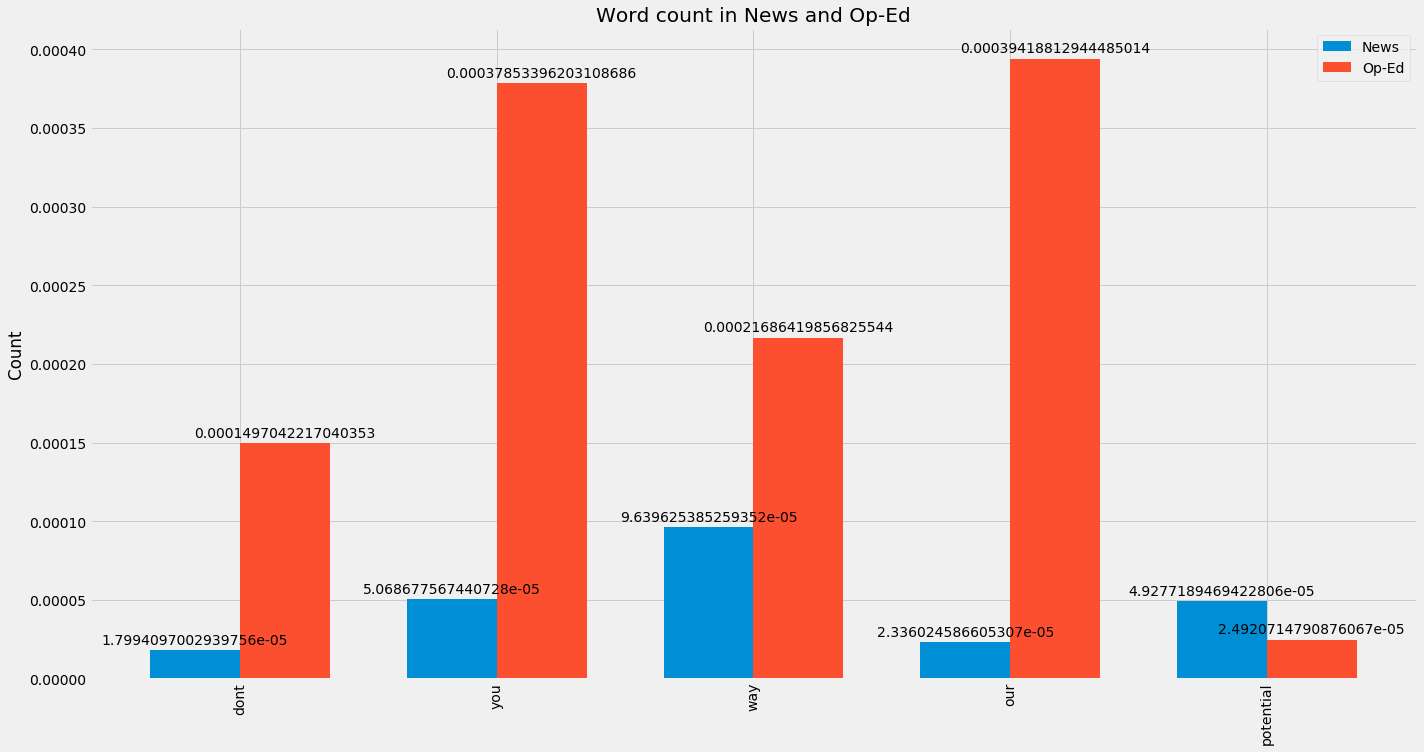

In [142]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

merge_dic = {}
for key, oped_val in oped_ed_counter.items():
    news_val = news_counter.get(key)
    merged_values = (news_val, oped_val)
    merge_dic[key] = merged_values

keys = []
news_counts = []
oped_counts = []
    
for k, v in merge_dic.items():
    keys.append(k)
    news_counts.append(v[0]/num_news_string)
    oped_counts.append(v[1]/num_oped_string)

x = np.arange(len(keys))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, news_counts, width, label='News')
rects2 = ax.bar(x + width/2, oped_counts, width, label='Op-Ed')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Word count in News and Op-Ed')
ax.set_xticks(x)
#ax.set_yscale('log')
ax.set_xticklabels(keys)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

# oped most common 

In [143]:
top_feat_total = feat_scores[-200:].index

In [144]:
%%time
oped_list_features = [word for word in oped_string.split() if word in list(top_feat_total)]
oped_ed_count_total = Counter(oped_list_features)

CPU times: user 47.7 s, sys: 88.3 ms, total: 47.8 s
Wall time: 47.8 s


In [145]:
%%time
news_list_features = [word for word in news_string.split() if word in list(top_feat_total)]
news_counter_total = Counter(news_list_features)

CPU times: user 3min 36s, sys: 543 ms, total: 3min 37s
Wall time: 3min 38s


In [146]:
%%time
merge_dic_total = {}
for key, oped_val in oped_ed_count_total.items():
    news_val = news_counter_total.get(key)
    merged_values_total = (news_val, oped_val)
    merge_dic_total[key] = merged_values_total

news_words = []
oped_words = []
    
for k, v in merge_dic_total.items():
    if v[0]/num_news_string > v[1]/num_oped_string:
        news_words.append(k)
    else:
        oped_words.append(k)

CPU times: user 289 µs, sys: 1 µs, total: 290 µs
Wall time: 298 µs


In [147]:
len(top_feat_total)

200

In [148]:
print(len(news_words))
print(len(oped_words))

57
143


In [149]:
news_words

['led',
 'offered',
 'among',
 'between',
 'president',
 'vice',
 'law',
 'first',
 'account',
 'signaled',
 'early',
 '2017',
 'concern',
 'impact',
 'immigration',
 'became',
 'focus',
 'concerned',
 'spring',
 'five',
 'firm',
 'related',
 'described',
 'raised',
 'conversation',
 'unit',
 'potential',
 'leave',
 'decided',
 'crowd',
 'dozen',
 'deportation',
 '12',
 'clothing',
 'submitted',
 'reviewed',
 'testimony',
 'predecessor',
 'chamber',
 'employee',
 'investigation',
 'bid',
 'consumer',
 'reporter',
 'board',
 'praised',
 'tension',
 'commercial',
 'protracted',
 'reviewing',
 'extensive',
 'manager',
 'indicated',
 'chairwoman',
 'file',
 'surfaced',
 'le']

In [150]:
oped_words

['dont',
 'here',
 'politics',
 'racism',
 'this',
 'whats',
 'going',
 'still',
 'poor',
 'thing',
 'you',
 'all',
 'make',
 'if',
 'many',
 'pretty',
 'probably',
 'no',
 'must',
 'now',
 'cynical',
 'put',
 'out',
 'man',
 'then',
 'isnt',
 'can',
 'sake',
 'way',
 'just',
 'anyone',
 'simple',
 'simply',
 'too',
 'turn',
 'understanding',
 'forget',
 'our',
 'remember',
 'care',
 'nothing',
 'am',
 'down',
 'common',
 'guy',
 'context',
 'getting',
 'itself',
 'because',
 'come',
 'democracy',
 'exactly',
 'wont',
 'authoritarian',
 'something',
 'moral',
 'find',
 'community',
 'youve',
 'thats',
 'old',
 'everything',
 'almost',
 'arent',
 'wasnt',
 'go',
 'youre',
 'doesnt',
 'every',
 'age',
 'movement',
 'surely',
 'stand',
 'earth',
 'reform',
 'ruthless',
 'smart',
 'happen',
 'wouldnt',
 'radical',
 'yourself',
 'hard',
 'presidency',
 'character',
 'serious',
 'themselves',
 'weve',
 'theyre',
 'bad',
 'century',
 'werent',
 'actual',
 'sense',
 'someone',
 'success',
 'bo

In [151]:
print(num_oped_string)
print(num_news_string)

102867068

In [130]:
# import matplotlib
# import matplotlib.pyplot as plt
# import numpy as np


# labels = oped_ed_counter.keys()
# #news_labels = news_counter.keys()

# oped_counts = oped_ed_counter.values()
# #news_counts = news_counter.values()

# x = np.arange(len(labels))  # the label locations
# width = 0.5  # the width of the bars

# fig, ax = plt.subplots(figsize=(10,10))
# rects1 = ax.bar(x - width/2, oped_counts, width, label='oped')
# #rects2 = ax.bar(x + width/2, news_counts, width, label='news')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# #ax.set_ylabel('Scores')
# ax.set_title('words in oped corpus')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# fig.tight_layout()
# plt.xticks(rotation=90)
# plt.show()

In [131]:
# import matplotlib
# import matplotlib.pyplot as plt
# import numpy as np


# labels = news_counter.keys()
# #news_labels = news_counter.keys()

# oped_counts = news_counter.values()
# #news_counts = news_counter.values()

# x = np.arange(len(labels))  # the label locations
# width = 0.5  # the width of the bars

# fig, ax = plt.subplots(figsize=(10,10))
# rects1 = ax.bar(x - width/2, oped_counts, width, label='news')
# #rects2 = ax.bar(x + width/2, news_counts, width, label='news')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# #ax.set_ylabel('Scores')
# ax.set_title('words in news corpus')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# fig.tight_layout()
# plt.xticks(rotation=90)
# plt.show()

### permutation importance

In [132]:
# %%time
# print(datetime.datetime.now())
# r = permutation_importance(rf_clf, X_test.toarray(), y_test, n_repeats=30, random_state=0)

In [133]:
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feat_names[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

In [134]:
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feat_names[i]:<20}")
# #               f"{r.importances_mean[i]:.3f}"
# #               f" +/- {r.importances_std[i]:.3f}")

In [135]:
len(feat_names)

44899

In [136]:
corpus[0]

' as you drew closer to the fifth floor where      works out of a suite of offices things started to loosen up  assistant outside his conference room wore a mask but the other did not  the middle of the room with its oil paintings and vaulted ceiling the long central table had fewer chairs than you might expect and an appropriate distance between them  past the next door inside the attorney generals smaller personal office  himself was also mask-free  around to greet his visitors he moved into the middle of a wide circle of four chairs arranged in front of his desk  nearing the end of his career  did not take his current job for the glory  had already been attorney general once in      administration winning him a reputation as a wise old man a reputation that in the eyes of some his tenure in the  administration has tarnished  is he doing it for the money  time in corporate  earned him tens of millions of dollars in compensation and stock options and his bearing is still that of a  50

In [137]:
features

NameError: name 'features' is not defined

# make a plot

In [ ]:
y

In [ ]:
min_df = np.linspace(0,.4,5)

In [ ]:
min_df

In [ ]:
corpus[0]

# min_df_plot

In [ ]:
%%time
num_feat_min = []

min_df = np.linspace(0.01,0.5,5)

for val in min_df:
    vectorizer_plot = TfidfVectorizer(preprocessor=punc_strip,
#                 tokenizer=wordnet_tokenize,
                stop_words=alphabet,
#                 max_df=0.95,
                 min_df=val,
                 max_features=None)
    
    vectorizer_plot.fit(X)
    
    features = vectorizer_plot.get_feature_names()
    stop_word = vectorizer_plot.get_stop_words()

    num_feat_min.append(len(features))

In [ ]:
learn_vect = TfidfVectorizer(preprocessor=punc_strip,
                 tokenizer=wordnet_tokenize,
#            stop_words=alphabet,
#                max_df=0.95,
             min_df=.2,
             max_features=None)

learn_vect.fit(X)

min_df_features = learn_vect.get_feature_names()
stop_word = learn_vect.get_stop_words()

In [ ]:
len(min_df_features)

In [ ]:
min_df_features

In [ ]:
%%time
fig, ax = plt.subplots()
ax.plot(min_df, num_feat_min);

# 

# max_features

In [ ]:
%%time
TN = []
FP = []
FN = []
TP = []

num_feat = np.linspace(1000,50000,6)

for val in num_feat:
    vectorizer_plot = TfidfVectorizer(preprocessor=punc_strip,
#                 tokenizer=wordnet_tokenize,
                stop_words=alphabet,
#                 max_df=0.95,
#                 min_df=val,
                 max_features=int(val))

    #test, train, split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

    X_train = vectorizer_plot.fit_transform(X_train)

    X_test = vectorizer_plot.transform(X_test)
    
    #X, y --> X_resampled, y_resampled
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    
    recall_rfc = RandomForestClassifier(max_depth=2, random_state=0)

    rf_clf.fit(X_resampled, y_resampled)
    y_pred = rf_clf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = y_pred).ravel()
    a, r, p  = metrics_(tn, fp, fn, tp)
    
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    
    
    num_feat_min.append(len(features))

In [ ]:
# for f in features:
#     model = RandomForestClassifier(max_features=f)
#     score = cross_val_score(model, X, y).mean()
#     print('A Random Forest Regressor with max features of: {} gets a score of {}'
#           .format(f,score))
#     scores.append(score)
    
# fig, ax = plt.subplots()
# ax.plot(features, scores)

In [ ]:
# for f in features:
#     model = RandomForestClassifier(max_features=f)
#     score = cross_val_score(model, X, y).mean()
#     print('A Random Forest Regressor with max features of: {} gets a score of {}'
#           .format(f,score))
#     scores.append(score)

In [ ]:
# #stacked bar graph

# video_sales_df = pd.read_excel("data.xlsx")

# regional_genre = video_sales_df.groupby(['Genre'],as_index=False)["NA_Sales","EU_Sales","JP_Sales"].sum()[:5]
# columns = ["NA_Sales","EU_Sales","JP_Sales"]

# # Normalization parameters
# normalize_min = 0.1
# normalize_max = 1

# # Normalize
# regional_genre[columns]= preprocessing.minmax_scale(regional_genre[columns], feature_range=(normalize_min, normalize_max))

# # Plot stacked bars
# plt.bar(regional_genre["Genre"], regional_genre["NA_Sales"], label="NA_Sales")
# plt.bar(regional_genre["Genre"], regional_genre["EU_Sales"], bottom=regional_genre["NA_Sales"], label="EU_Sales")
# plt.bar(regional_genre["Genre"], regional_genre["JP_Sales"], bottom=regional_genre["EU_Sales"]+regional_genre["NA_Sales"], label="JP_Sales")
# plt.legend()
# plt.ylabel("Normalized sales")
# plt.show()

# # Another solution for plot:

# plt.bar(columns, regional_genre.ix[0,1:], label="Action")
# bot = regional_genre.ix[0,1:]
# plt.bar(columns, regional_genre.ix[1,1:], bottom=bot, label="Adventure")
# bot += regional_genre.ix[1,1:]
# plt.bar(columns, regional_genre.ix[2,1:], bottom=bot, label="Fighting")
# bot += regional_genre.ix[2,1:]
# plt.bar(columns, regional_genre.ix[3,1:], bottom=bot, label="Misc")
# bot += regional_genre.ix[3,1:]
# plt.bar(columns, regional_genre.ix[4,1:], bottom=bot, label="Platform")